In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import PIL.Image as Image

In [2]:
# G U-Net

# Conv block
class Conv(nn.Module):
    def __init__(self, in_channels,out_channels):
        super(Conv,self).__init__()

        # same size
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,padding=1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(out_channels,out_channels,3,padding=1,bias=False),
            nn.LeakyReLU(0.2,inplace=True)
        )
    
    def forward(self,x):
        return self.double_conv(x)

# Super resloution
class superR(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(superR,self).__init__()

        self.deConv = nn.Sequential(
            nn.ConvTranspose2d(in_channels,in_channels,4,stride=2,padding=1),
            nn.BatchNorm2d(in_channels),
            nn.LeakyReLU(0.2,inplace=True),

            nn.ConvTranspose2d(in_channels,out_channels,4,stride=2,padding=1),
            nn.Tanh()
        )

    def forward(self,x):
        return self.deConv(x)

class UNet(nn.Module):
    def __init__(self):
        super(UNet,self).__init__()

        self.down1 = Conv(3,64)
        self.down2 = Conv(64,128)
        self.down3 = Conv(128,256)
        self.down4 = Conv(256,512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2,mode='bilinear',align_corners=True)

        self.up3 = Conv(256+512,256)
        self.up2 = Conv(128+256,128)
        self.up1 = Conv(64+128,64)

        # super resolution
        self.super = superR(64,3)

    def forward(self,x):
        # encode
        conv1 = self.down1(x)
        x = self.maxpool(conv1)
        # print('1',x.shape)

        conv2 = self.down2(x)
        x = self.maxpool(conv2)
        # print('2',x.shape)

        conv3 = self.down3(x)
        x = self.maxpool(conv3)
        # print('3',x.shape)

        x = self.down4(x)
        # print('4',x.shape)

        # decode
        x = self.upsample(x)
        x = torch.cat([x,conv3],dim=1)
        x = self.up3(x)
        # print('5',x.shape)

        x = self.upsample(x)
        x = torch.cat([x,conv2],dim=1)
        x = self.up2(x)
        # print('6',x.shape)

        x = self.upsample(x)
        x = torch.cat([x,conv1],dim=1)
        x = self.up1(x)

        x = self.super(x)

        return x



In [3]:
# load weight
flag_gpu = 1
device = 'cuda:0' if (torch.cuda.is_available() & flag_gpu) else 'cpu'
print('GPU State:', device)

model = UNet().to(device)
model.load_state_dict(torch.load('pix2pix_Generator.pth'))
model.eval()

GPU State: cuda:0


UNet(
  (down1): Conv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down2): Conv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down3): Conv(
    (double_conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): Leak

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 256, 256])
torch.Size([3, 256, 256])
(3, 256, 256)


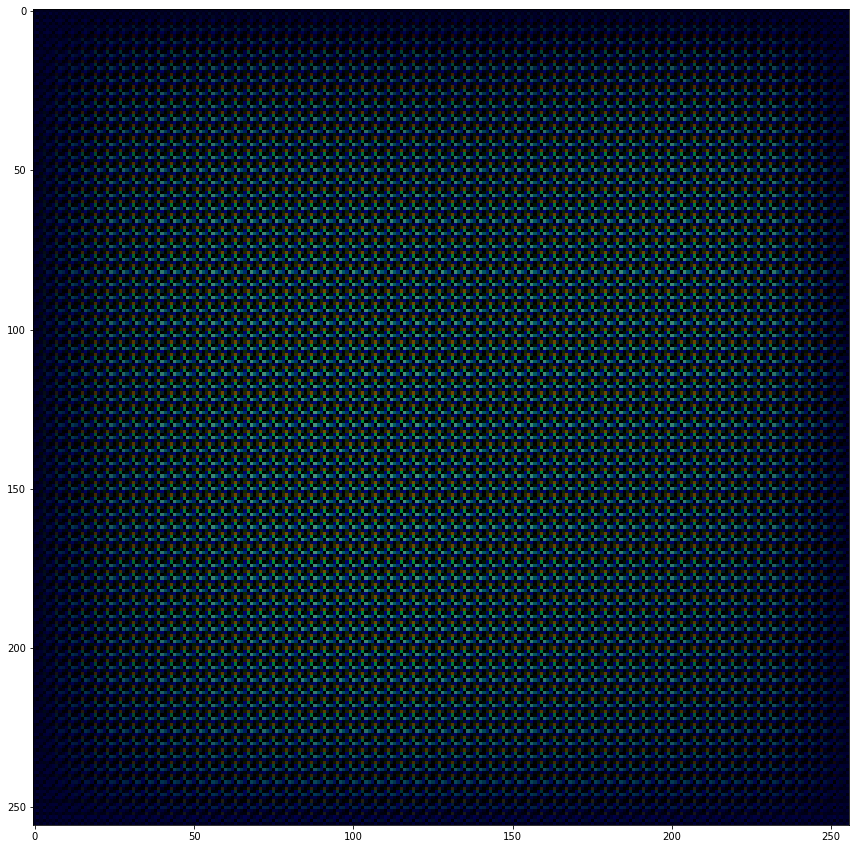

In [4]:

# load image
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

train_set = datasets.ImageFolder('./inf',transform=transforms.Compose([
                                                transforms.Resize([256,256]),
                                                transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
T = transforms.Resize(size=(64,64))

for data, targets in train_loader:
    break
print(data.shape)

img = data[0]
print(img.shape)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(img,(1,2,0)))

in_img = T(data).to(device)
prediction = model(in_img)
prediction = prediction[0].cpu().detach().numpy()
print(prediction.shape)
plt.imshow(np.transpose(prediction,(1,2,0)))

# def to_img(x):
#     x = x.clamp(0, 1)
#     return x

# def visualise_output(model):

#     with torch.no_grad():
    
#         noise = 
#         noise = noise.to(device)
#         images = model(noise)
#         images = images.cpu()
#         images = to_img(images)
        
#         np_imagegrid = torchvision.utils.make_grid(images[0:16], 4, 4).numpy()
#         plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
#         plt.show()

# # plt.show()
# visualise_output(model)

